In [1]:
import cache
from glob import glob
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pickle
import polars as pl
import seaborn as sns
from sklearn.metrics import auc, precision_recall_curve, precision_score, recall_score, f1_score
from statistics import mean

In [2]:
dataset_names = [
    'abt-buy', 'amazon-google', 'walmart-amazon',
    'wdc_xlarge_computers', 'wdc_xlarge_shoes', 'wdc_xlarge_watches'
]
CONST_N = 5

In [3]:
def get_results(key):
    results = {
        'f1': [],
        'precision': [],
        'recall': [],
        'threshold': [],
        'f1_0.5': [],
        'precision_0.5': [],
        'threshold_0.5': [],
        'recall_0.5': []
    }
    for train in range(1, 6):
        all_y_prob = []
        for fold in range(10):
            epoch = sorted(
                glob(f'entity-matching-transformer/experiments/{key.upper()}-{train}-{fold}*/test_*.pickle'),
                key=lambda x: int(x.split('_')[-1].split('.')[0]),
                reverse=True
            )[0].split('_')[-1].split('.')[0]
            with open(glob(f'entity-matching-transformer/experiments/{key.upper()}-{train}-{fold}*/validation_{epoch}.pickle')[0], 'rb') as f:
                temp = pickle.load(f)
            all_y_prob.append(pl.DataFrame().select(
                pl.Series('y_prob', temp['probabilities'][:,1]),
                pl.Series('label', temp['labels']).cast(bool),
                pl.lit(fold).alias('fold'),
                pl.lit('val').alias('set')
            ).with_row_count('N').with_columns(
                pl.col('N') % 5
            ))
            with open(glob(f'entity-matching-transformer/experiments/{key.upper()}-{train}-{fold}*/test_{epoch}.pickle')[0], 'rb') as f:
                temp = pickle.load(f)
            all_y_prob.append(pl.DataFrame().select(
                pl.Series('y_prob', temp['probabilities'][:,1]),
                pl.Series('label', temp['labels']).cast(bool),
                pl.lit(fold).alias('fold'),
                pl.lit('test').alias('set')
            ).with_row_count('N').with_columns(
                pl.col('N') % 5
            ))
        all_y_prob = pl.concat(all_y_prob)
        for k in results:
            results[k].append([])
        for test in range(1, 6):
            for k in results:
                results[k][-1].append([])
            for fold in range(10):
                # find best threshold
                subset = all_y_prob.filter(pl.col('label') | (pl.col('N') < train))
                y_val = subset.filter(pl.col('set') == 'val')['label'].to_list()
                y_prob = subset.filter(pl.col('set') == 'val')['y_prob'].to_numpy()
                precision, recall, threshold = precision_recall_curve(y_val, y_prob)
                with np.errstate(divide='ignore', invalid='ignore'):
                    f1_scores = np.nan_to_num(2 * recall * precision / (recall + precision))
                threshold = threshold[np.argmax(f1_scores)]
                results['threshold'][-1][-1].append(threshold)

                # get test set results
                subset = all_y_prob.filter(pl.col('label') | (pl.col('N') < test))
                y_test = subset.filter(pl.col('set') == 'test')['label'].to_list()
                y_prob = subset.filter(pl.col('set') == 'test')['y_prob'].to_numpy()
                y_pred = y_prob > threshold
                results['precision'][-1][-1].append(precision_score(y_test, y_pred, zero_division=0.0))
                results['recall'][-1][-1].append(recall_score(y_test, y_pred))
                results['f1'][-1][-1].append(f1_score(y_test, y_pred))

                y_pred = y_prob > 0.5
                results['precision_0.5'][-1][-1].append(precision_score(y_test, y_pred, zero_division=0.0))
                results['recall_0.5'][-1][-1].append(recall_score(y_test, y_pred))
                results['threshold_0.5'][-1][-1].append(0.5)
                results['f1_0.5'][-1][-1].append(f1_score(y_test, y_pred))

            for k in results:
                results[k][-1][-1] = mean(results[k][-1][-1])
    return results

dl_results = {key: get_results(key) for key in set(dataset_names)}

In [4]:
rf_results = {}
for key in ['abt-buy', 'amazon-google', 'wdc_xlarge_computers', 'wdc_xlarge_shoes', 'wdc_xlarge_watches']:
    rf_results[key] = cache.load(f'random_forest/{key}_results')
rf_results['walmart-amazon'] = cache.load('random_forest/products_(Walmart-Amazon)_results')

In [5]:
svm_results = {}
for key in ['abt-buy', 'amazon-google', 'wdc_xlarge_computers', 'wdc_xlarge_shoes', 'wdc_xlarge_watches']:
    svm_results[key] = cache.load(f'svm_rbf/{key}_results')
svm_results['walmart-amazon'] = cache.load('svm_rbf/products_(Walmart-Amazon)_results')

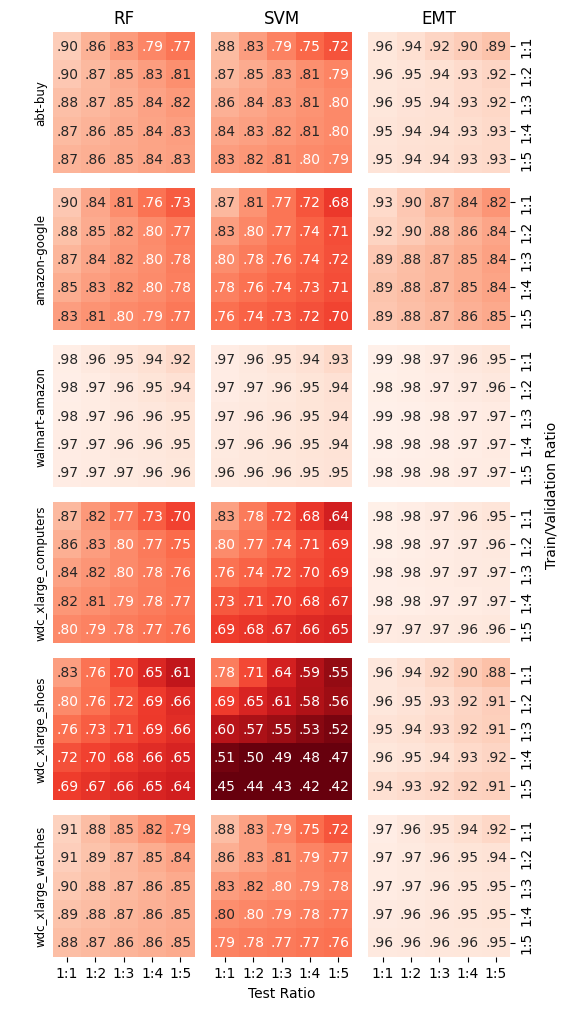

In [6]:
def plot(ax, results):
    sns.heatmap(
        np.pad(np.array(results), (0, CONST_N - 5)),
        mask=~np.pad(np.full((5, 5), True), (0, CONST_N - 5)),
        annot=np.vectorize(lambda a: f'{a:.2}'[1:].ljust(3, '0').replace('.00', '1.0'))(np.pad(np.array(results), (0, CONST_N - 5))),
        cmap='Reds_r',
        cbar=False,
        fmt='s',
        ax=ax,
        vmin=0.5,
        vmax=1,
        xticklabels=[f'1:{i}' for i in range(1, 6)],
        square=True
    )
    ax.yaxis.tick_right()
    ax.set_yticklabels([f'1:{i}' for i in range(1, 6)], va='center')
    ax.tick_params(bottom=False, right=False, labelbottom=False, labelright=False)

fig, axes = plt.subplots(6, 3, figsize=(6,10.5))
for i, key in enumerate(dataset_names):
    plot(axes[i][0], rf_results[key]['f1_0.5'])
    plot(axes[i][1], svm_results[key]['f1_0.5'])
    plot(axes[i][2], dl_results[key]['f1_0.5'])

for i, label in enumerate(['RF', 'SVM', 'EMT']):
    axes[0][i].set_title(label, fontsize=12)
    
for i, label in enumerate(dataset_names):
    axes[i][0].set_ylabel(label, fontsize=8.5)

for r in range(6):
    axes[r][2].tick_params(right=True, labelright=True)
for c in range(3):
    axes[5][c].tick_params(bottom=True, labelbottom=True)

# add a big axis, hide frame
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Test Ratio')
ax.yaxis.set_label_position("right")
ax.set_ylabel('Train/Validation Ratio', labelpad=17)
plt.tight_layout()
plt.show()

# abt-buy

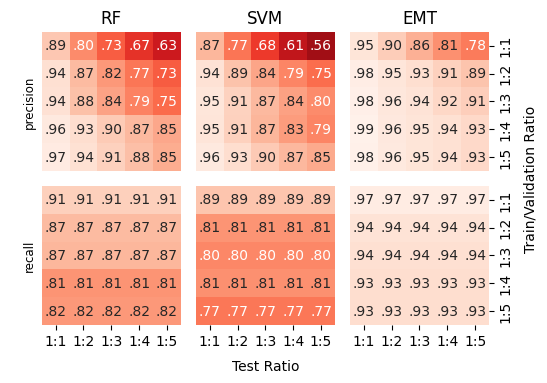

# amazon-google

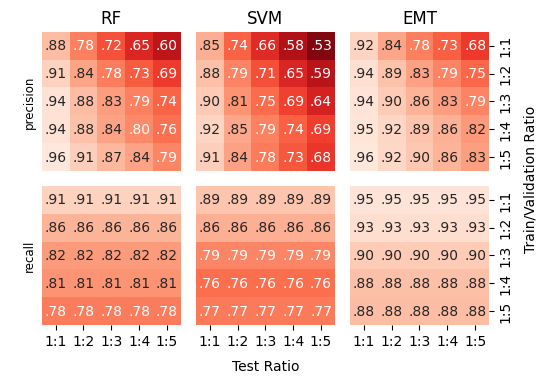

# walmart-amazon

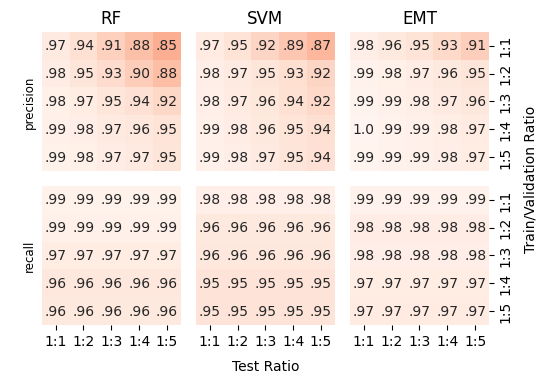

# wdc_xlarge_computers

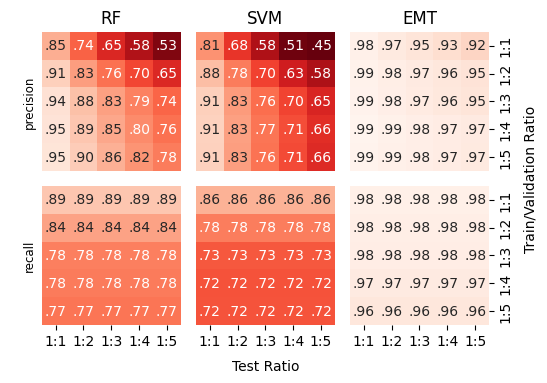

# wdc_xlarge_shoes

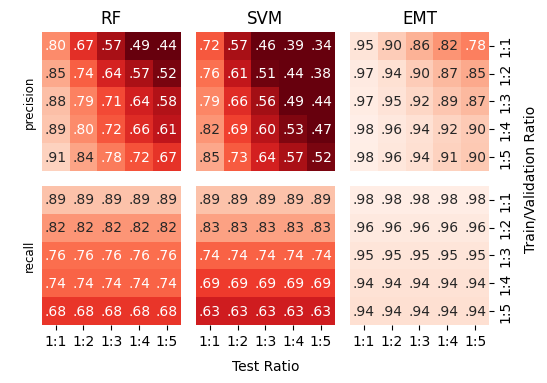

# wdc_xlarge_watches

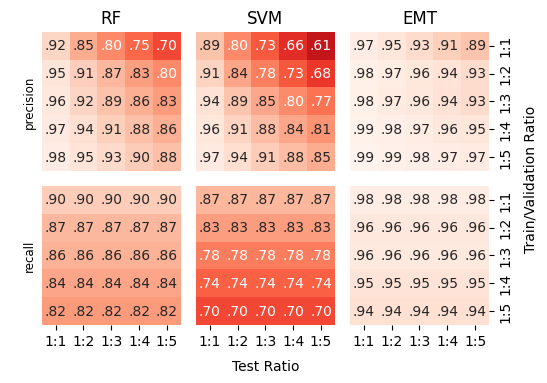

In [7]:
def plot(ax, results):
    sns.heatmap(
        np.pad(np.array(results), (0, CONST_N - 5)),
        mask=~np.pad(np.full((5, 5), True), (0, CONST_N - 5)),
        annot=np.vectorize(lambda a: f'{a:.2}'[1:].ljust(3, '0').replace('.00', '1.0'))(np.pad(np.array(results), (0, CONST_N - 5))),
        cmap='Reds_r',
        cbar=False,
        fmt='s',
        ax=ax,
        vmin=0.5,
        vmax=1,
        xticklabels=[f'1:{i}' for i in range(1, 6)],
        square=True
    )
    ax.yaxis.tick_right()
    ax.set_yticklabels([f'1:{i}' for i in range(1, 6)], va='center')
    ax.tick_params(bottom=False, right=False, labelbottom=False, labelright=False)

for key in dataset_names:
    fig, axes = plt.subplots(2, 3, figsize=(6,4.18))
    plot(axes[0][0], rf_results[key]['precision'])
    plot(axes[0][1], svm_results[key]['precision'])
    plot(axes[0][2], dl_results[key]['precision'])
    plot(axes[1][0], rf_results[key]['recall'])
    plot(axes[1][1], svm_results[key]['recall'])
    plot(axes[1][2], dl_results[key]['recall'])

    for i, label in enumerate(['RF', 'SVM', 'EMT']):
        axes[0][i].set_title(label, fontsize=12)

    for i, label in enumerate(['precision', 'recall']):
        axes[i][0].set_ylabel(label, fontsize=8.5)

    for r in range(2):
        axes[r][2].tick_params(right=True, labelright=True)
    for c in range(3):
        axes[1][c].tick_params(bottom=True, labelbottom=True)

    # add a big axis, hide frame
    ax = fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Test Ratio')
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('Train/Validation Ratio', labelpad=25)
    plt.tight_layout()
    display(Markdown(f'# {key}'))
    plt.show()